# Time Series Analysis Working Notebook

# Import Initial Libraries

#### The source of our data 
- Zillow and Missouri Census Data Center 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot

In [2]:
raw_df = pd.read_csv('zillow_data.csv')

In [3]:
raw_df = raw_df[raw_df['State']=='TX']
raw_df.drop(raw_df.columns[np.r_[0,3,4,6]], axis=1, inplace=True)
raw_df = raw_df.rename(columns={'RegionName': 'zipcode'})

In [4]:
raw_df

,zipcode,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,75070,McKinney,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,79936,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,77084,Houston,Harris,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,Harris,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,Irion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,122500,121800,121600,122200,123500,124700,124300,122600,121600,121600
14472,79313,Anton,Hockley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55400,56300,55700,56300,58900,61500,63000,63600,63500,63300
14492,79355,Plains,Yoakum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100500,100500,101000,100700,99700,97700,95800,94600,94000,93500
14599,79366,Ransom Canyon,Lubbock,134500.0,134500.0,134400.0,134400.0,134300.0,134200.0,134200.0,...,252100,251600,251600,251500,251300,251500,251700,252500,255000,257500


In [5]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['1996-04'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(raw_df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = raw_df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = raw_df[raw_df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725246

 Best 5 Zipcodes:


,zipcode,ROI,CV
5130,77020,1.641221,0.170703
6646,76104,1.304225,0.171104
9106,75956,1.255220,0.170555
225,75217,1.248485,0.169633
4123,77091,1.208904,0.170921


In [6]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250160 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [8]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [9]:
df_income = pd.read_csv('zip_codes_2019_median_inc.csv')
df_income['state'] = df_income['Preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['Type'] != 'PO box'])
df_income

,ZIP Code,Type,State FIPS,Preferred name,Alternate names,Population (2019),Housing units (2019),Median family income (2019),MFI percentile (2019),Latitude,Longitude,Land area,Water area,state
31142,73301,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31143,73344,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31744,75001,standard,48,"Addison, TX",NaN,"14,992","9,298","$79,551",68.0,32.959999,-96.838997,3.834,0.003,TX
31745,75002,standard,48,"Allen, TX","Lucas, Parker","71,253","23,314","$105,656",88.0,33.090000,-96.609001,37.179,2.056,TX
31746,75006,standard,48,"Carrollton, TX",NaN,"51,642","19,178","$72,325",57.0,32.962002,-96.899002,16.875,0.254,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34257,79961,unique,48,"El Paso, TX",El Paso Water Utilities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34258,79968,unique,48,"El Paso, TX",Univ Of Tx Elp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34259,79976,unique,48,"El Paso, TX",Southern Union Gas Co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
34260,79978,unique,48,"El Paso, TX",El Paso Natural Gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX


In [10]:
df_income = df_income.rename(columns={'Population (2019)': 'population', 
                        'Housing units (2019)': 'housing_units',
                         'ZIP Code': 'zipcode'})

In [11]:
df_income['Median family income (2019)'] = df_income['Median family income (2019)'].str.strip('$\n\t')
df_income['Median family income (2019)'] = df_income['Median family income (2019)'].str.replace(',','')
df_income = df_income[df_income['Median family income (2019)'].notna()]
df_income['median_family_income'] = df_income['Median family income (2019)'].astype(int)

In [12]:
df_income.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zipcode                      1623 non-null   int64  
 1   Type                         1623 non-null   object 
 2   State FIPS                   1623 non-null   int64  
 3   Preferred name               1623 non-null   object 
 4   Alternate names              689 non-null    object 
 5   population                   1623 non-null   object 
 6   housing_units                1623 non-null   object 
 7   Median family income (2019)  1623 non-null   object 
 8   MFI percentile (2019)        1623 non-null   float64
 9   Latitude                     1623 non-null   float64
 10  Longitude                    1623 non-null   float64
 11  Land area                    1623 non-null   float64
 12  Water area                   1623 non-null   float64
 13  state        

In [13]:
df_income.drop(df_income.columns[np.r_[1:5,7,8,11,12]], axis=1, inplace=True)

In [14]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   object 
 2   housing_units         1623 non-null   object 
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
 6   median_family_income  1623 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 101.4+ KB


In [15]:
# df_merged = df.merge(df_income, on ='zipcode')
df_merged = df.reset_index().merge(df_income, how="left").set_index('date')
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income
date,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996,"104,415","38,662",33.172001,-96.695999,TX,115530.0
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996,"118,291","38,449",29.740999,-95.830002,TX,148843.0
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996,"111,620","37,267",31.777000,-106.296997,TX,61016.0
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,"107,673","37,968",29.827000,-95.660004,TX,70460.0
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,"128,294","38,672",29.837999,-95.734001,TX,82716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,"1,455",783,31.271999,-100.889000,TX,64464.0
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,"1,528",744,33.805000,-102.162003,TX,49250.0
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,"1,877",738,33.181999,-102.876999,TX,64563.0


In [16]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [17]:
df_merged['affordability'] = df_merged['value'] - df_merged['median_family_income']/.12
df_merged['affordability'] = NormalizeData(df_merged['affordability'])
df_merged['affordability_score'] = (df_merged['affordability'] - df_merged['affordability'].mean())/df_merged['affordability'].std()
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996,"104,415","38,662",33.172001,-96.695999,TX,115530.0,0.515600,-1.092372
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996,"118,291","38,449",29.740999,-95.830002,TX,148843.0,0.349509,-2.595256
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996,"111,620","37,267",31.777000,-106.296997,TX,61016.0,0.677839,0.375657
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,"107,673","37,968",29.827000,-95.660004,TX,70460.0,0.644391,0.073005
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,"128,294","38,672",29.837999,-95.734001,TX,82716.0,0.588609,-0.431747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,"1,455",783,31.271999,-100.889000,TX,64464.0,0.686374,0.452891
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,"1,528",744,33.805000,-102.162003,TX,49250.0,0.723925,0.792672
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018,"1,877",738,33.181999,-102.876999,TX,64563.0,0.670514,0.309380


In [18]:
# Select the first quantile
q1 = df['value'].quantile(.25)

# Select the third quantile
q3 = df['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df[(df['value']>=q1) 
             & (df['value']<=q3)]
filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018


In [19]:
df_merged['population'] = df_merged['population'].str.strip(',')
df_merged['population'] = df_merged['population'].str.replace(',','')
df_merged = df_merged[df_merged['population'].notna()]
df_merged['population'] = df_merged['population'].astype(int)
df_merged

<ipython-input-19-6051d07dd1a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['population'] = df_merged['population'].astype(int)


,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996,104415,"38,662",33.172001,-96.695999,TX,115530.0,0.515600,-1.092372
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996,118291,"38,449",29.740999,-95.830002,TX,148843.0,0.349509,-2.595256
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996,111620,"37,267",31.777000,-106.296997,TX,61016.0,0.677839,0.375657
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996,107673,"37,968",29.827000,-95.660004,TX,70460.0,0.644391,0.073005
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996,128294,"38,672",29.837999,-95.734001,TX,82716.0,0.588609,-0.431747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018,1481,719,29.284000,-95.281998,TX,76382.0,0.647050,0.097068
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018,1455,783,31.271999,-100.889000,TX,64464.0,0.686374,0.452891
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018,1528,744,33.805000,-102.162003,TX,49250.0,0.723925,0.792672


In [20]:
df_merged['affordability_score']

date
1996-04-01   -1.092372
1996-04-01   -2.595256
1996-04-01    0.375657
1996-04-01    0.073005
1996-04-01   -0.431747
                ...   
2018-04-01    0.097068
2018-04-01    0.452891
2018-04-01    0.792672
2018-04-01    0.309380
2018-04-01   -0.954897
Name: affordability_score, Length: 252181, dtype: float64

In [21]:
# Select the first quantile
q1 = df['value'].quantile(.25)

# Select the third quantile
q3 = df['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df[(df['value']>=q1) 
             & (df['value']<=q3)]
filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018


In [22]:
top_20 = df_merged['affordability_score'].quantile(.2)
df_merged_20 = df_merged[(df_merged['affordability_score'] <top_20)]
df_merged_20 = df_merged_20['2017-01-01':]
df_merged_20

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,300800.0,2017,104415,"38,662",33.172001,-96.695999,TX,115530.0,0.551295,-0.769378
2017-01-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,323700.0,2017,118291,"38,449",29.740999,-95.830002,TX,148843.0,0.411634,-2.033117
2017-01-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,245400.0,2017,88131,"31,342",29.504000,-95.086998,TX,121943.0,0.491615,-1.309397
2017-01-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,245300.0,2017,90372,"32,487",29.545000,-95.350998,TX,126143.0,0.472369,-1.483546
2017-01-01,78613,Cedar Park,Williamson,0.752948,30849.586207,209259.245283,0.147423,285000.0,2017,81943,"28,334",30.504000,-97.823997,TX,115556.0,0.542513,-0.848845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78619,Driftwood,Hays,0.721477,59801.535970,361680.377358,0.165344,513000.0,2018,4505,"1,571",30.112000,-98.033997,TX,141607.0,0.548494,-0.794723
2018-04-01,77534,Danbury,Brazoria,1.212081,22688.458345,114705.660377,0.197797,164800.0,2018,2256,961,29.232000,-95.314003,TX,107262.0,0.514503,-1.102295
2018-04-01,79068,Panhandle,Carson,0.878261,12159.925347,80253.584906,0.151519,108000.0,2018,3489,"1,483",35.347000,-101.444000,TX,99922.0,0.516897,-1.080630


In [23]:
#Descriptive statistics of coefficients of variance.
print(df_merged_20.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_merged_20.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df_merged_20[df_merged_20['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:60]
                                                                                        
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV', 'affordability']]

count    1987.000000
mean        0.161781
std         0.029075
min         0.112610
25%         0.142428
50%         0.157155
75%         0.172381
max         0.306666
Name: CV, dtype: float64

CV upper limit: 0.16335172280385973

 Best 5 Zipcodes:


,zipcode,ROI,CV,affordability
date,,,,
2018-03-01,75205,0.981878,0.163310,0.465981
2018-04-01,75205,0.981878,0.163310,0.467517
2018-01-01,75205,0.981878,0.163310,0.457427
2017-07-01,75205,0.981878,0.163310,0.442239
2017-04-01,75205,0.981878,0.163310,0.436975
2017-05-01,75205,0.981878,0.163310,0.440155
2018-02-01,75205,0.981878,0.163310,0.461869
2017-12-01,75205,0.981878,0.163310,0.455070
2017-08-01,75205,0.981878,0.163310,0.446461


In [24]:
zipcode =[75205, 76126, 78669, 75009, 77459]
df_merged = df_merged[df_merged['zipcode'].isin(zipcode)]
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,housing_units,Latitude,Longitude,state,median_family_income,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,77459,Missouri City,Fort Bend,0.914427,30612.040554,195526.415094,0.156562,141400.0,1996,72788,"23,640",29.528999,-95.524002,TX,126525.0,0.413653,-2.014842
1996-04-01,75205,University Park,Dallas,0.981878,143754.799103,880259.622642,0.163310,640100.0,1996,24877,"10,737",32.835999,-96.795998,TX,250001.0,0.122897,-4.645768
1996-04-01,76126,Benbrook,Tarrant,0.965061,21988.457703,139099.245283,0.158077,105900.0,1996,23450,"9,523",32.636002,-97.502998,TX,109918.0,0.470071,-1.504343
1996-04-01,78669,Spicewood,Travis,0.953570,45409.494836,281990.566038,0.161032,200300.0,1996,12901,"6,179",30.430000,-98.112999,TX,130506.0,0.427759,-1.887207
1996-04-01,75009,Celina,Collin,0.928073,37017.619960,227114.339623,0.162991,186300.0,1996,14089,"4,568",33.339001,-96.752998,TX,117857.0,0.477880,-1.433683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,77459,Missouri City,Fort Bend,0.914427,30612.040554,195526.415094,0.156562,270700.0,2018,72788,"23,640",29.528999,-95.524002,TX,126525.0,0.484551,-1.373318
2018-04-01,75205,University Park,Dallas,0.981878,143754.799103,880259.622642,0.163310,1268600.0,2018,24877,"10,737",32.835999,-96.795998,TX,250001.0,0.467517,-1.527456
2018-04-01,76126,Benbrook,Tarrant,0.965061,21988.457703,139099.245283,0.158077,208100.0,2018,23450,"9,523",32.636002,-97.502998,TX,109918.0,0.526109,-0.997277


#### Size of our Data
- 1325

### Limitations
- Working on Modeling

In [25]:
df = pd.DataFrame(filtered)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018


In [26]:
# df.drop(df.columns[np.r_[9:18,20,21]], axis=1, inplace=True)

In [27]:
df_merged['median_family_income'].isna().sum()

0

In [28]:
df_prices = pd.DataFrame(df_merged[['zipcode', 'value']], index = df_merged.index)
df_prices

,zipcode,value
date,,
1996-04-01,77459,141400.0
1996-04-01,75205,640100.0
1996-04-01,76126,105900.0
1996-04-01,78669,200300.0
1996-04-01,75009,186300.0
...,...,...
2018-04-01,77459,270700.0
2018-04-01,75205,1268600.0
2018-04-01,76126,208100.0


In [29]:
df_p = df_prices.reset_index()
df_p

,date,zipcode,value
0,1996-04-01,77459,141400.0
1,1996-04-01,75205,640100.0
2,1996-04-01,76126,105900.0
3,1996-04-01,78669,200300.0
4,1996-04-01,75009,186300.0
...,...,...,...
1320,2018-04-01,77459,270700.0
1321,2018-04-01,75205,1268600.0
1322,2018-04-01,76126,208100.0
1323,2018-04-01,78669,391300.0


In [30]:
df_p = df_p.pivot("date", "zipcode", "value")


In [31]:
df_p

zipcode,75009,75205,76126,77459,78669
date,,,,,
1996-04-01,186300.0,640100.0,105900.0,141400.0,200300.0
1996-05-01,185200.0,637000.0,105800.0,140500.0,201000.0
1996-06-01,184100.0,634200.0,105700.0,140000.0,201700.0
1996-07-01,183000.0,631800.0,105700.0,139700.0,202300.0
1996-08-01,182000.0,630200.0,105600.0,139700.0,202900.0
...,...,...,...,...,...
2017-12-01,340800.0,1245900.0,198800.0,267800.0,374300.0
2018-01-01,343200.0,1250200.0,199900.0,268000.0,375800.0
2018-02-01,348000.0,1258300.0,201600.0,268900.0,378900.0


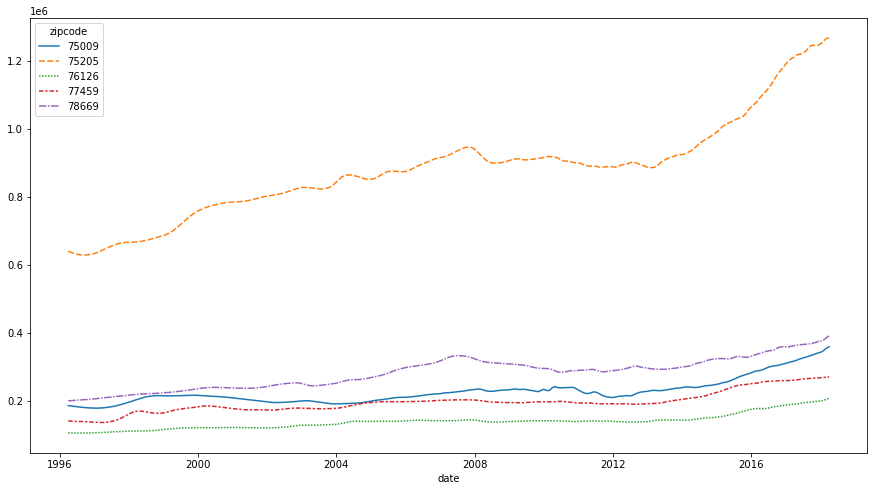

In [32]:
fig, ax = plt.subplots()
sns.lineplot(data=df_p);
fig.set_size_inches(15,8);

<ipython-input-55-5fd6d88f6e38>:1: RuntimeWarning: invalid value encountered in log
  df_log = np.log(df_roll).dropna()


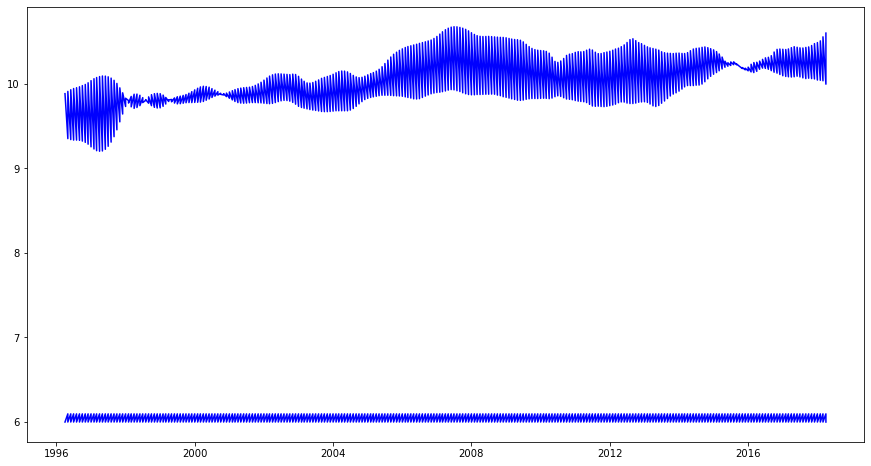

In [55]:
df_log = np.log(df_roll).dropna()
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');

In [56]:
df_log_wrm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529 entries, 1996-04-01 to 2018-04-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   zipcode  529 non-null    float64
 1   value    529 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


zipcodes =[75205, 76126, 78669, 75009, 77459]

for zipcode in zipcodes:
    pipeline = Pipeline(steps =[ 
                    ('arima', ARIMA(df_log_wrm['zipcode'], order=(1, 0, 0)))],                        
                    verbose=True)
    X, y = make_classification(random_state=0) 
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                               random_state=0)
    pipeline.fit(df_log_wrm['zipcode'])
    #y_pred = pipeline.predict(X_train)
    #mean_squared_error(y_pred, y_train, squared=False)

<AxesSubplot:xlabel='date'>

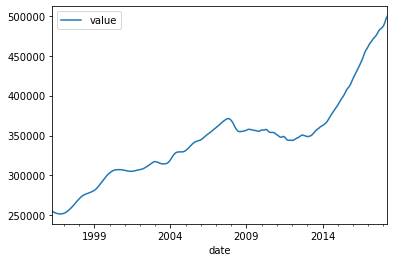

In [37]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

<AxesSubplot:xlabel='date'>

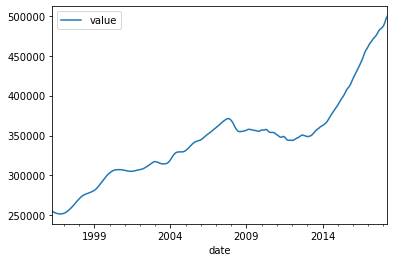

In [38]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

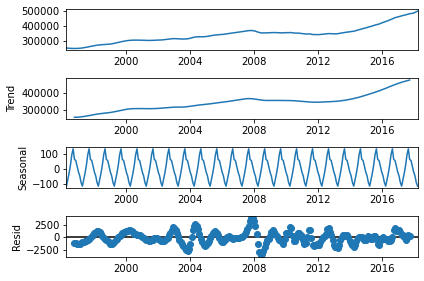

In [39]:
seasonal_avg = seasonal_decompose(avg_prices, model='additive')
seasonal_avg.plot()
pyplot.show()

<AxesSubplot:xlabel='date'>

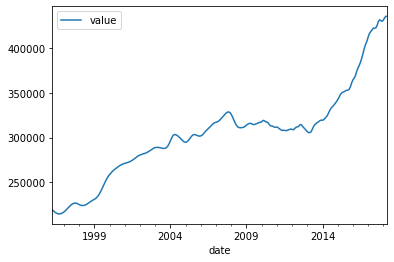

In [40]:
std_prices = df_prices.groupby('date').aggregate({'value':'std'})
std_prices.plot()

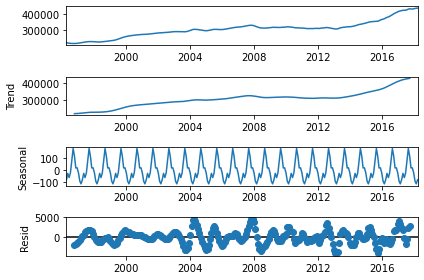

In [41]:
seasonal_std = seasonal_decompose(std_prices, model='additive')
seasonal_std.plot()
pyplot.show()

<AxesSubplot:xlabel='date'>

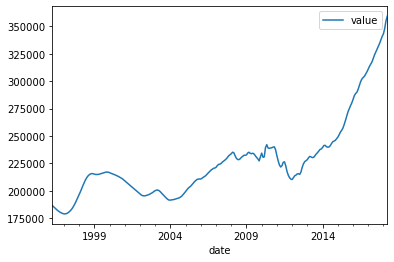

In [42]:
med_prices = df_prices.groupby('date').aggregate({'value':'median'})
med_prices.plot()

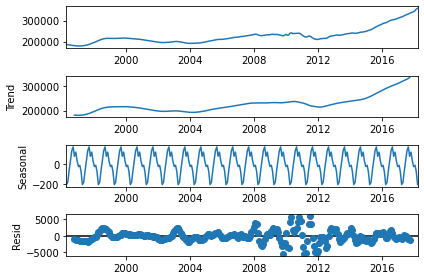

In [43]:
seasonal_med = seasonal_decompose(med_prices, model='additive')
seasonal_med.plot()
pyplot.show()

In [44]:
df_diff = df_prices.diff().dropna()

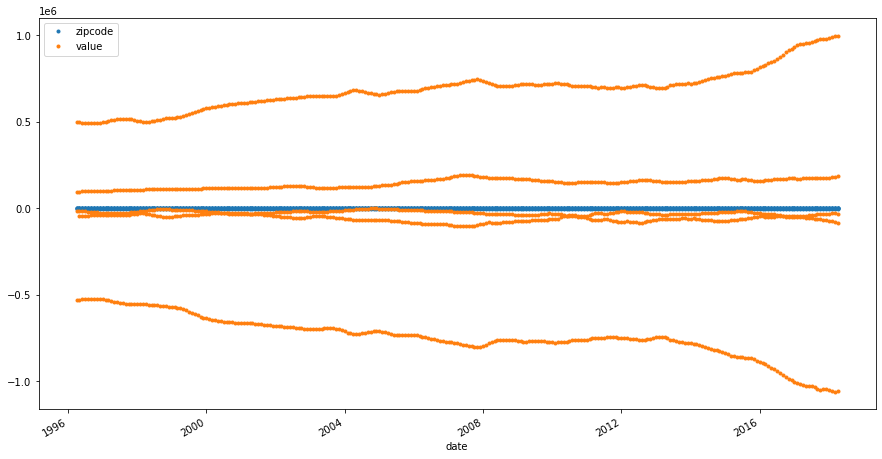

In [45]:
df_prices.diff().plot(figsize = (15, 8), style = '.');

In [46]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

In [47]:
results = stationarity_check(df_diff)
results 

ValueError: x is required to have ndim 1 but has ndim 2

In [48]:
results = stationarity_check(df_diff)
results

ValueError: x is required to have ndim 1 but has ndim 2

<AxesSubplot:xlabel='date'>

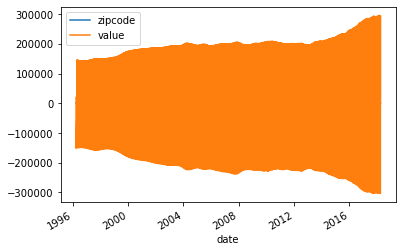

In [49]:
df_roll = df_prices.diff().rolling(3).mean()
df_roll.plot()

<ipython-input-50-5fd6d88f6e38>:1: RuntimeWarning: invalid value encountered in log
  df_log = np.log(df_roll).dropna()


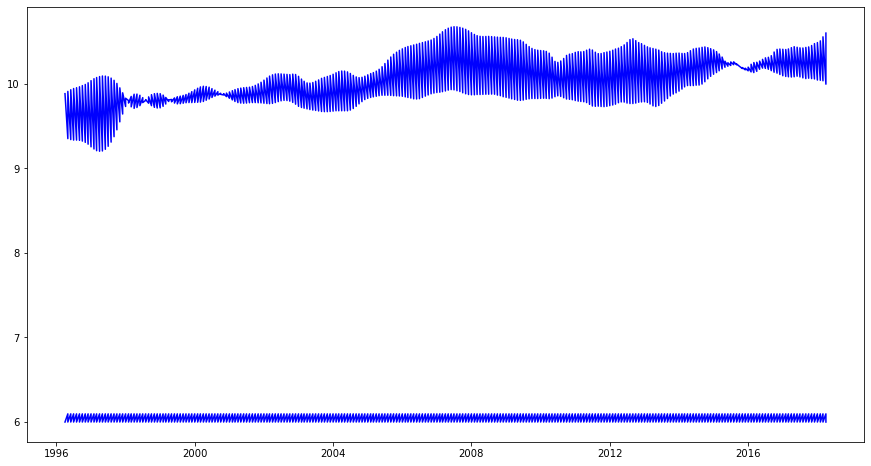

In [50]:
df_log = np.log(df_roll).dropna()
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');

In [51]:
results = stationarity_check(df_log)
results 

ValueError: x is required to have ndim 1 but has ndim 2

<AxesSubplot:xlabel='date'>

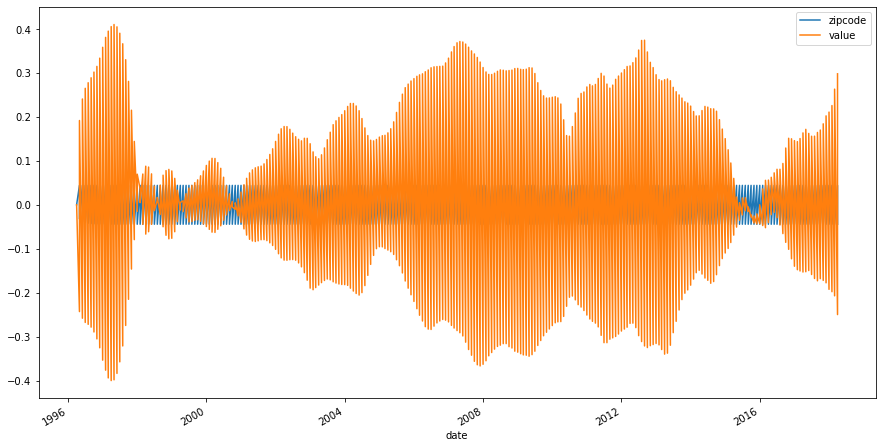

In [52]:
weight_roll_mean = df_log.ewm(halflife=4).mean()
df_log_wrm = df_log - weight_roll_mean
df_log_wrm.plot(figsize=(15,8))

In [53]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


ValueError: SARIMAX models require univariate `endog`. Got shape (529, 2).

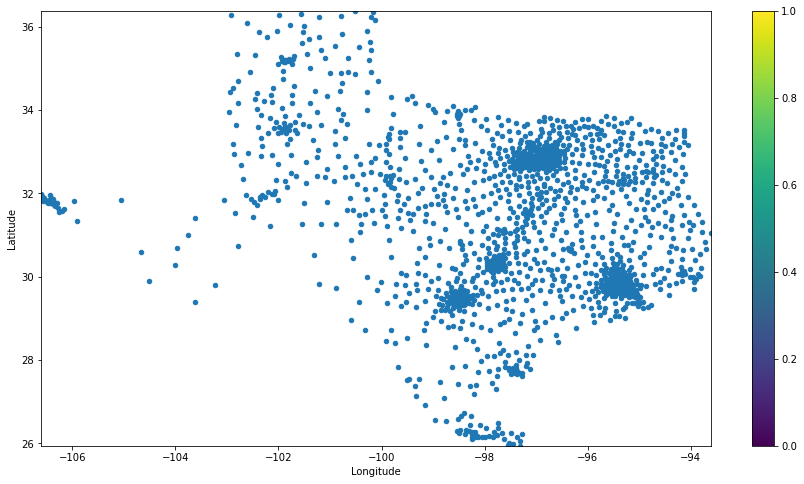

In [54]:
fig, ax = plt.subplots()

cmap = sns.cubehelix_palette(as_cmap=True)
points = ax.scatter(df_income['Longitude'], df_income['Latitude'], s=20, cmap='Blues')


ax.set_xlim((df_income['Longitude'].min(), df_income['Longitude'].max()))
ax.set_ylim((df_income['Latitude'].min(), df_income['Latitude'].max()))
fig.colorbar(points)
fig.set_size_inches(15,8)
plt.xlabel("Longitude")
plt.ylabel("Latitude");